In [1]:
from IPython.display import clear_output

In [2]:
!pip install open-clip-torch
!pip install faiss-cpu
!pip install faiss-gpu
clear_output()

In [3]:
import os, cv2, faiss, torch, numpy as np
from PIL import Image
from tqdm import tqdm
from IPython.display import display

In [4]:
BACKEND = os.environ.get("MM_BACKEND", "siglip2")  # "openclip" | "siglip2"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
if BACKEND == "openclip":
    import open_clip
    OC_MODEL = "ViT-g-14"
    OC_PRETRAINED = "laion2b_s34b_b88k"
    model, _, preprocess = open_clip.create_model_and_transforms(
        OC_MODEL, pretrained=OC_PRETRAINED, device=DEVICE
    )
    tokenizer = open_clip.get_tokenizer(OC_MODEL)
    model.eval()

elif BACKEND == "siglip2":
    # pip install -U transformers accelerate bitsandbytes
    from transformers import AutoProcessor, AutoModel
    CKPT = os.environ.get("SIGLIP2_CKPT", "google/siglip2-giant-opt-patch16-384")
    processor = AutoProcessor.from_pretrained(CKPT)
    model = AutoModel.from_pretrained(CKPT, device_map="auto").eval()
else:
    raise ValueError("BACKEND phải là 'openclip' hoặc 'siglip2'.")

2025-08-25 11:40:06.454457: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756122006.648595      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756122006.704280      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.49G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
@torch.no_grad()
def embed_images(image_paths, batch_size=64):
    """
    frames: list[np.ndarray(H,W,3) in RGB]
    return: np.ndarray [N, D] đã L2-norm
    """
    if BACKEND == "openclip":
        vecs = []
        for i in range(0, len(image_paths), batch_size):
            batch = [preprocess(Image.open(path)) for path in image_paths[i:i+batch_size]]
            batch = torch.stack(batch).to(DEVICE)
            feats = model.encode_image(batch)
            feats = feats / feats.norm(dim=-1, keepdim=True)
            vecs.append(feats.float().cpu().numpy())
        return np.vstack(vecs)

    elif BACKEND == "siglip2":
        from PIL import Image as _Image
        vecs = []
        pil_frames = [Image.open(path) for path in image_paths]
        for i in range(0, len(pil_frames), batch_size):
            batch = pil_frames[i:i+batch_size]
            inputs = processor(images=batch, return_tensors="pt").to(model.device)
            img_feats = model.get_image_features(**inputs)  # (B, D)
            img_feats = img_feats / img_feats.norm(dim=-1, keepdim=True)
            vecs.append(img_feats.float().cpu().numpy())
        return np.vstack(vecs)

In [6]:
@torch.no_grad()
def embed_query_vi(text, en_hint=None):
    """
    Trả về vector 1xD đã L2-norm; nếu có en_hint -> lấy max giữa 2 biến thể.
    """
    if BACKEND == "openclip":
        texts = [text] + ([en_hint] if en_hint else [])
        toks = tokenizer(texts).to(DEVICE)
        feats = model.encode_text(toks)
        feats = feats / feats.norm(dim=-1, keepdim=True)
        feat = torch.max(feats, dim=0).values
        return feat.float().cpu().numpy()[None, :]

    elif BACKEND == "siglip2":
        texts = [text.lower()] + ([en_hint.lower()] if en_hint else [])
        inputs = processor(
            text=texts, return_tensors="pt",
            padding="max_length", max_length=64
        ).to(model.device)
        txt_feats = model.get_text_features(**inputs)
        txt_feats = txt_feats / txt_feats.norm(dim=-1, keepdim=True)
        feat = torch.max(txt_feats, dim=0).values
        return feat.float().cpu().numpy()[None, :]

In [7]:
# ======= FAISS =======
def build_index(vecs: np.ndarray):
    faiss.normalize_L2(vecs) 
    idx = faiss.IndexFlatIP(vecs.shape[1])
    idx.add(vecs)
    return idx

In [8]:
# # ======= SEARCH =======
# def search_frames(image_paths, query_vi, query_en_hint=None,
#                   topk=10, save_dir="hits", show=True):
#     os.makedirs(save_dir, exist_ok=True)

#     print(f"Số frame sample: {len(image_paths)}")
#     if not image_paths:
#         return []

#     print("Nhúng ảnh...")
#     img_vecs = embed_images(image_paths)
#     index = build_index(img_vecs)

#     print("Nhúng truy vấn...")
#     qv = embed_query_vi(query_vi, query_en_hint)

#     print("Tìm top-k...")
#     D, I = index.search(qv.astype("float32"), topk)
#     I, D = I[0].tolist(), D[0].tolist()

#     base = os.path.splitext(os.path.basename(image_paths[0]))[0]
#     results = []
#     for rank, (idx, score) in enumerate(zip(I, D), 1):
#         thumb = Image.open(image_paths[idx])
#         out = os.path.join(save_dir, f"{base}_rank{rank:02d}_score{score:.3f}.jpg")
#         thumb.save(out, quality=92)
#         results.append({
#             "rank": rank, "similarity": float(score),
#             "thumb": out, "frame_index": int(idx)
#         })
#         if show:
#             print(f"Rank {rank} | score {score:.3f} | {out}")
#             display(thumb)

#     return results


In [9]:
import pickle

def save_image_embeddings(image_paths, save_path="image_embeddings.pkl"):
    print(f"Lưu embeddings của {len(image_paths)} ảnh...")
    
    # Nhúng ảnh
    img_vecs = embed_images(image_paths)
    
    # Lưu embeddings vào file
    with open(save_path, 'wb') as f:
        pickle.dump(img_vecs, f)
    
    print(f"Đã lưu embeddings vào {save_path}")


In [10]:
import pickle
import numpy as np
import os
from PIL import Image

def search_frames_with_saved_embeddings(image_paths, query_vi, query_en_hint=None, 
                                        topk=10, save_dir="hits", embedding_path="image_embeddings.pkl", show=True):
    # Kiểm tra nếu file embeddings đã tồn tại
    if not os.path.exists(embedding_path):
        raise FileNotFoundError(f"Không tìm thấy file embeddings: {embedding_path}")
    
    # Đọc embeddings đã lưu
    with open(embedding_path, 'rb') as f:
        img_vecs = pickle.load(f)
    
    # Tạo chỉ mục cho embeddings đã lưu
    index = build_index(img_vecs)

    print(f"Số frame sample: {len(image_paths)}")
    if not image_paths:
        return []

    print("Nhúng truy vấn...")
    qv = embed_query_vi(query_vi, query_en_hint)

    print("Tìm top-k...")
    D, I = index.search(qv.astype("float32"), topk)
    I, D = I[0].tolist(), D[0].tolist()

    base = os.path.splitext(os.path.basename(image_paths[0]))[0]
    results = []
    
    os.makedirs(save_dir, exist_ok=True)
    
    for rank, (idx, score) in enumerate(zip(I, D), 1):
        thumb = Image.open(image_paths[idx])
        out = os.path.join(save_dir, f"{base}_rank{rank:02d}_score{score:.3f}.jpg")
        thumb.save(out, quality=92)
        results.append({
            "rank": rank, "similarity": float(score),
            "thumb": out, "frame_index": int(idx)
        })
        if show:
            print(f"Rank {rank} | score {score:.3f} | {out}")
            display(thumb)

    return results


In [11]:
import os

In [12]:
file_path = '/kaggle/input/aic-small-2024/Keyframes_L21/keyframes/L21_V001'
image_names = os.listdir(file_path)
image_paths = []
for i in range(len(image_names)):
    image_paths.append(os.path.join(file_path, image_names[i]))

In [13]:
import json
import cv2

json_file = '/kaggle/input/aic-sample-test/keyframes_index/L21_V003_keyframes_index.json'
with open(json_file, 'r') as f:
    frame_indices = json.load(f)

video_path = '/kaggle/input/aic-sample-test/videos/L21_V003.mp4'


In [14]:
# Mở video
cap = cv2.VideoCapture(video_path)

# Kiểm tra video có mở thành công không
if not cap.isOpened():
    print("Không thể mở video.")
    exit()

In [15]:
# Tạo thư mục lưu các frame nếu chưa tồn tại
output_dir = 'extracted_frames'
os.makedirs(output_dir, exist_ok=True)

# Danh sách lưu các đường dẫn tới frame đã trích xuất
image_paths = []

# Lấy tất cả các index frame từ file JSON
for idx, frame_index in enumerate(frame_indices):
    # Đặt vị trí video tới frame cần lấy
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)

    # Đọc frame
    ret, frame = cap.read()
    if not ret:
        print(f"Không thể đọc frame tại index {frame_index}.")
        continue

    # Chuyển đổi từ BGR (OpenCV) sang RGB (PIL)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Lưu frame dưới dạng ảnh PNG
    frame_image = Image.fromarray(frame_rgb)
    frame_path = os.path.join(output_dir, f'frame_{frame_index}.png')
    frame_image.save(frame_path)
    
    # Thêm đường dẫn của frame vào danh sách image_paths
    image_paths.append(frame_path)

# Giải phóng tài nguyên
cap.release()

# In ra số lượng frame đã trích xuất
print(f"Đã trích xuất {len(frame_indices)} frame.")
print("Các đường dẫn frame:", image_paths)

[h264 @ 0x34b8fe40] mmco: unref short failure
[h264 @ 0x34b8fe40] mmco: unref short failure
[h264 @ 0x34b8fe40] mmco: unref short failure
[h264 @ 0x34b8fe40] mmco: unref short failure


Đã trích xuất 349 frame.
Các đường dẫn frame: ['extracted_frames/frame_2.png', 'extracted_frames/frame_238.png', 'extracted_frames/frame_301.png', 'extracted_frames/frame_340.png', 'extracted_frames/frame_362.png', 'extracted_frames/frame_394.png', 'extracted_frames/frame_428.png', 'extracted_frames/frame_453.png', 'extracted_frames/frame_494.png', 'extracted_frames/frame_519.png', 'extracted_frames/frame_536.png', 'extracted_frames/frame_560.png', 'extracted_frames/frame_594.png', 'extracted_frames/frame_622.png', 'extracted_frames/frame_665.png', 'extracted_frames/frame_696.png', 'extracted_frames/frame_745.png', 'extracted_frames/frame_776.png', 'extracted_frames/frame_810.png', 'extracted_frames/frame_1441.png', 'extracted_frames/frame_1509.png', 'extracted_frames/frame_1600.png', 'extracted_frames/frame_1668.png', 'extracted_frames/frame_1721.png', 'extracted_frames/frame_1802.png', 'extracted_frames/frame_1894.png', 'extracted_frames/frame_1926.png', 'extracted_frames/frame_1993.

In [16]:
save_image_embeddings(image_paths, "image_embeddings.pkl")

Lưu embeddings của 349 ảnh...
Đã lưu embeddings vào image_embeddings.pkl


Số frame sample: 349
Nhúng truy vấn...
Tìm top-k...
Rank 1 | score 0.165 | hits/frame_2_rank01_score0.165.jpg


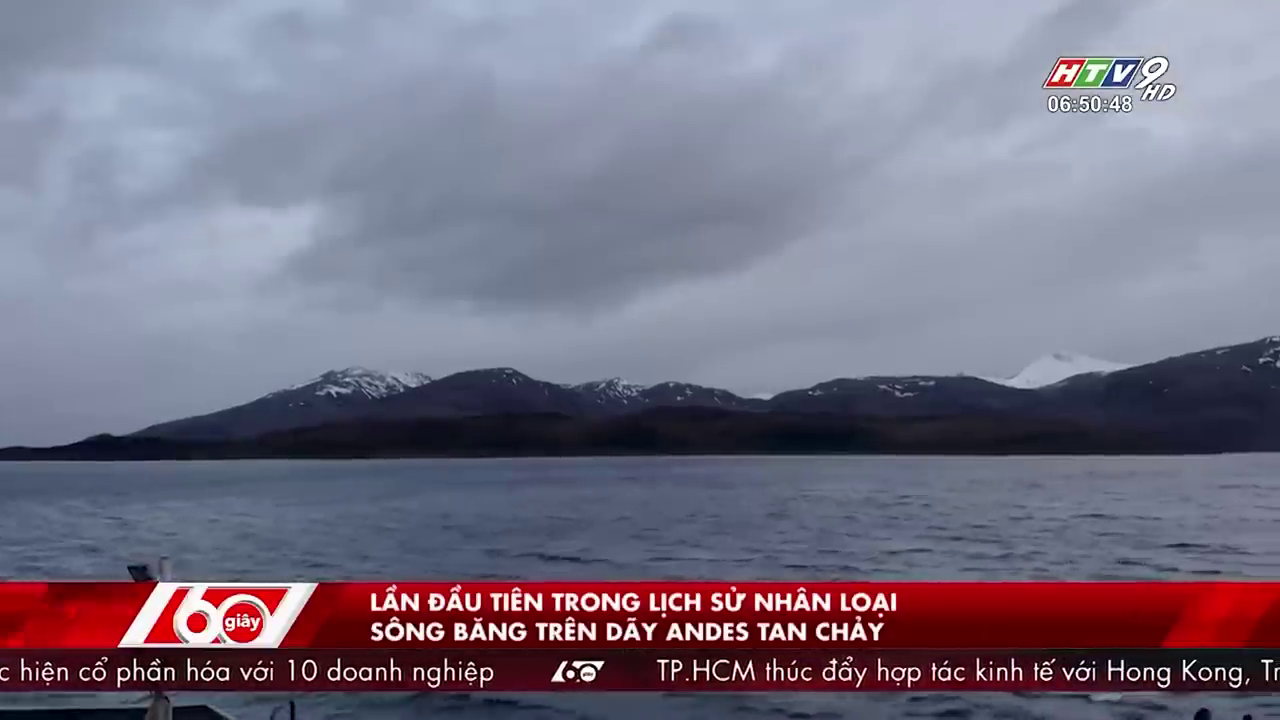

Rank 2 | score 0.160 | hits/frame_2_rank02_score0.160.jpg


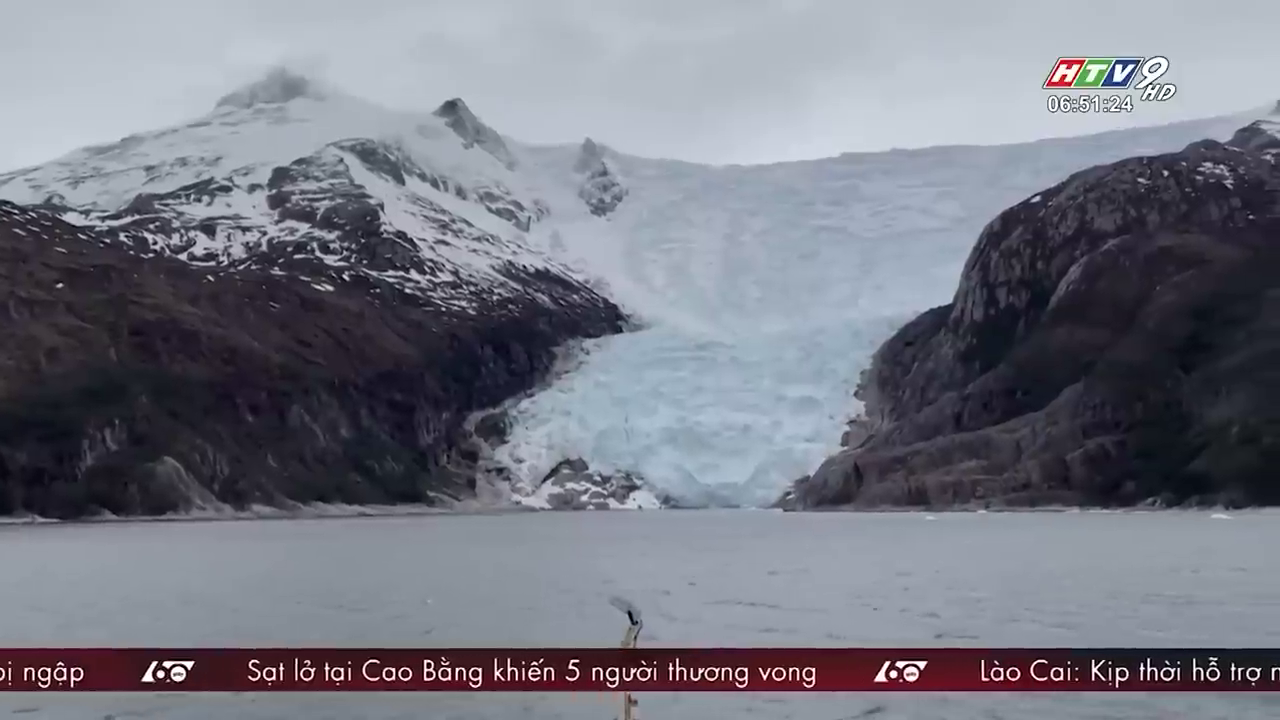

Rank 3 | score 0.157 | hits/frame_2_rank03_score0.157.jpg


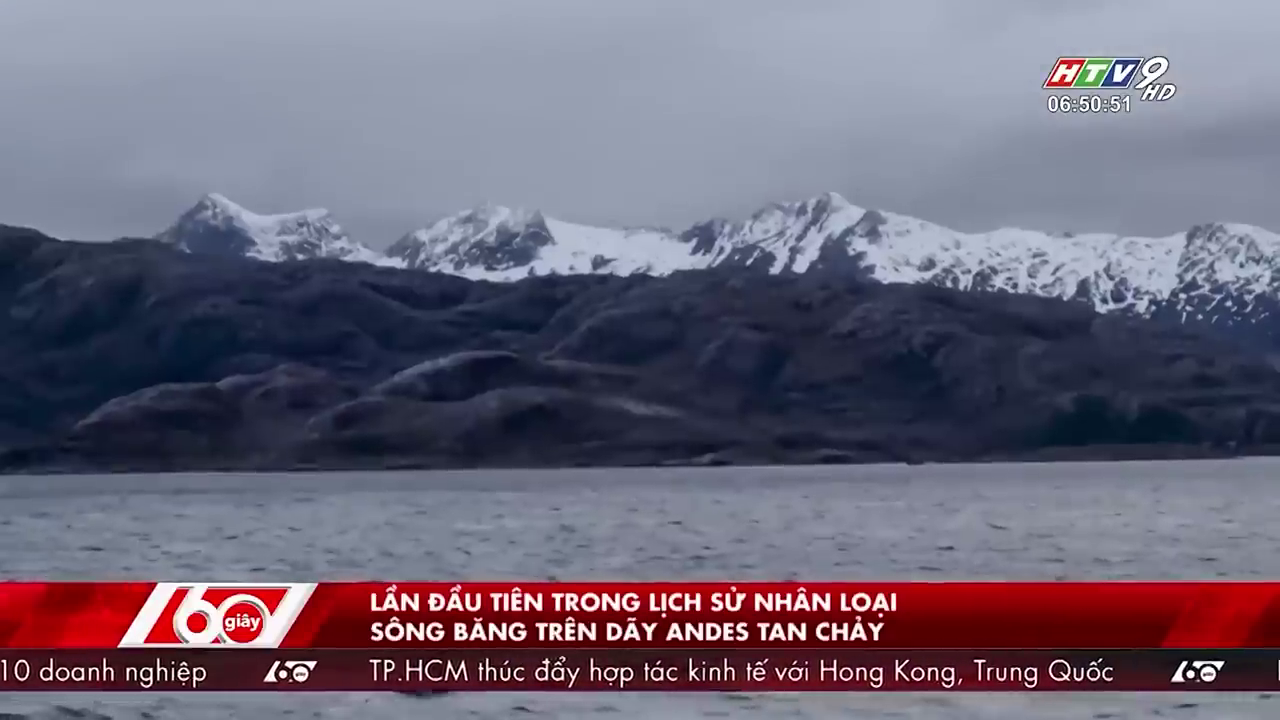

Rank 4 | score 0.155 | hits/frame_2_rank04_score0.155.jpg


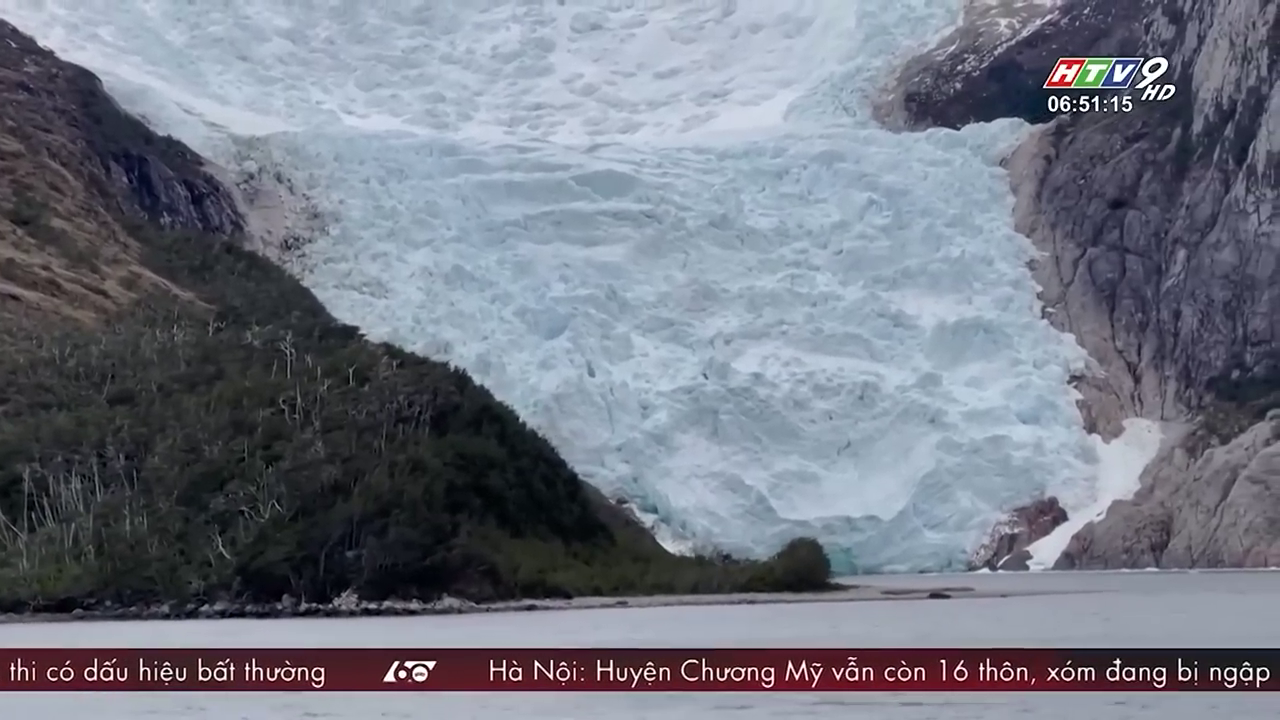

Rank 5 | score 0.152 | hits/frame_2_rank05_score0.152.jpg


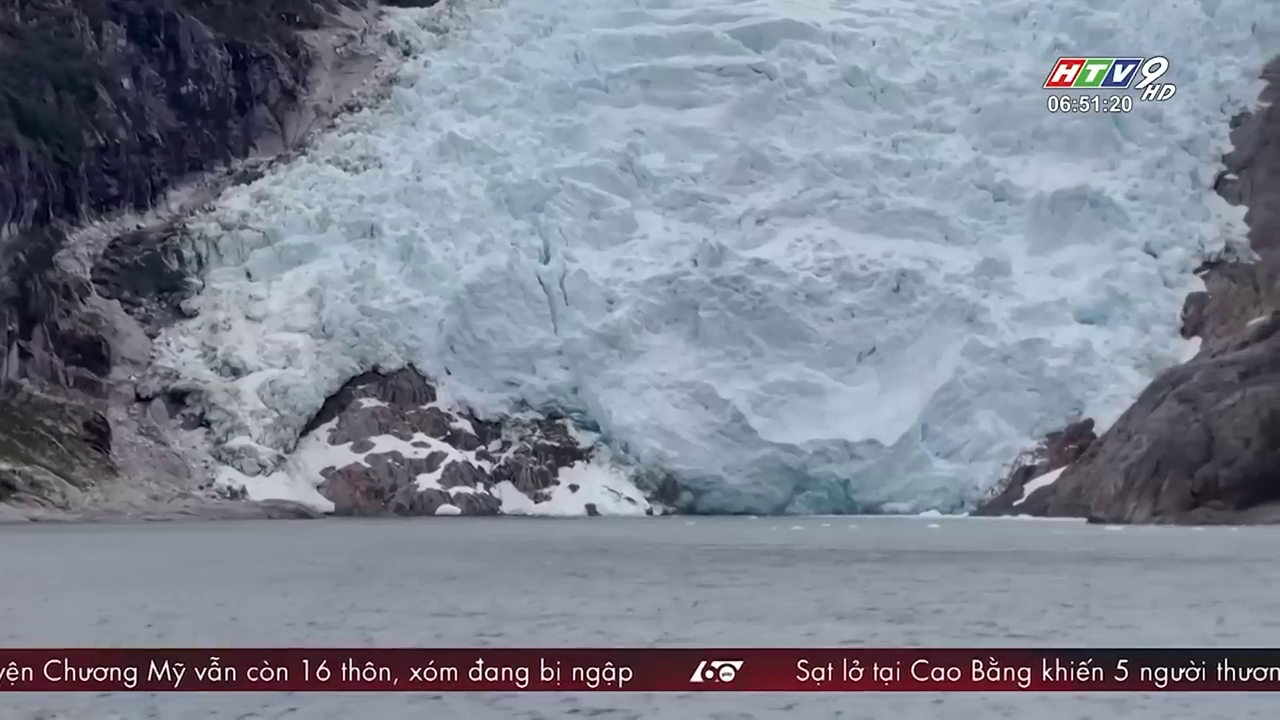

Rank 6 | score 0.147 | hits/frame_2_rank06_score0.147.jpg


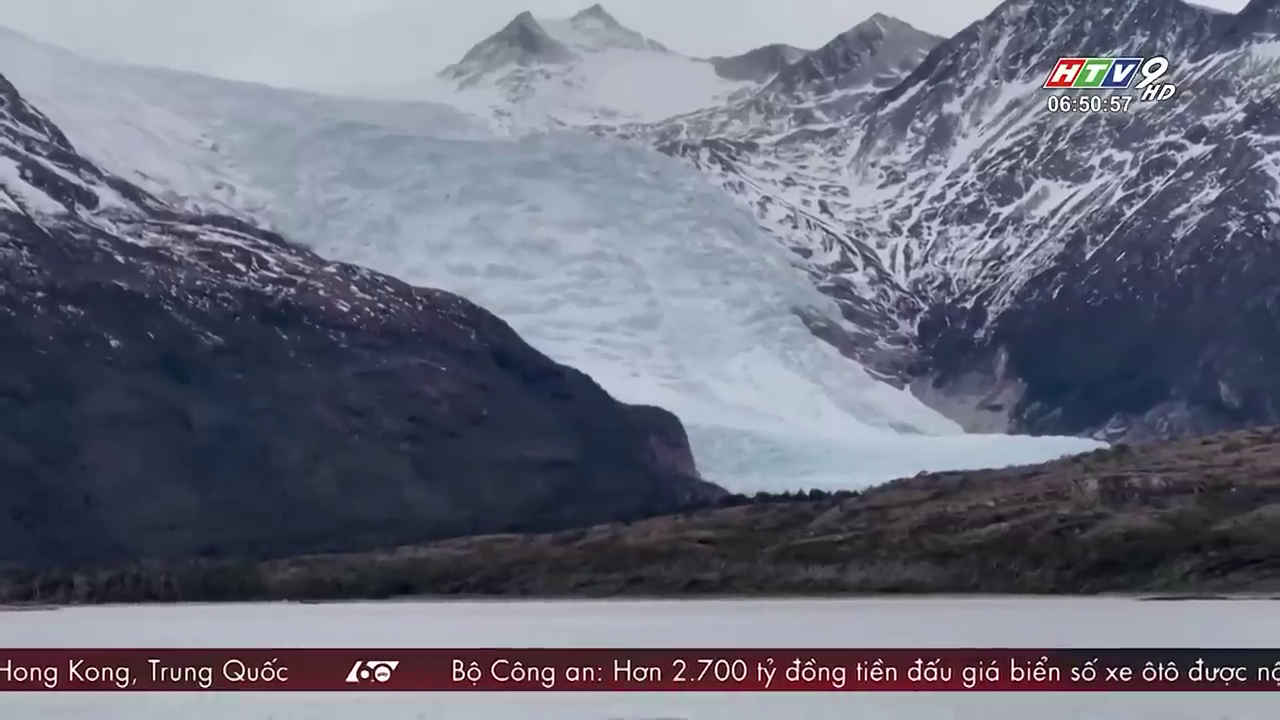

Rank 7 | score 0.141 | hits/frame_2_rank07_score0.141.jpg


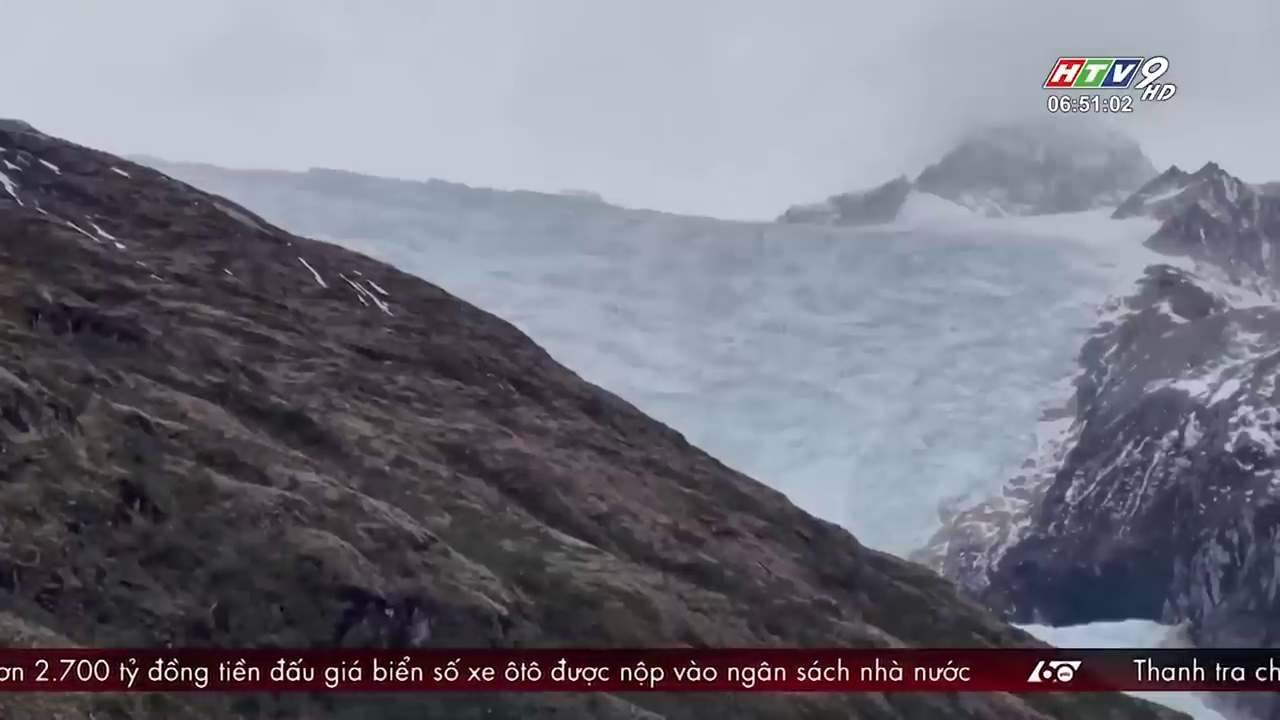

Rank 8 | score 0.139 | hits/frame_2_rank08_score0.139.jpg


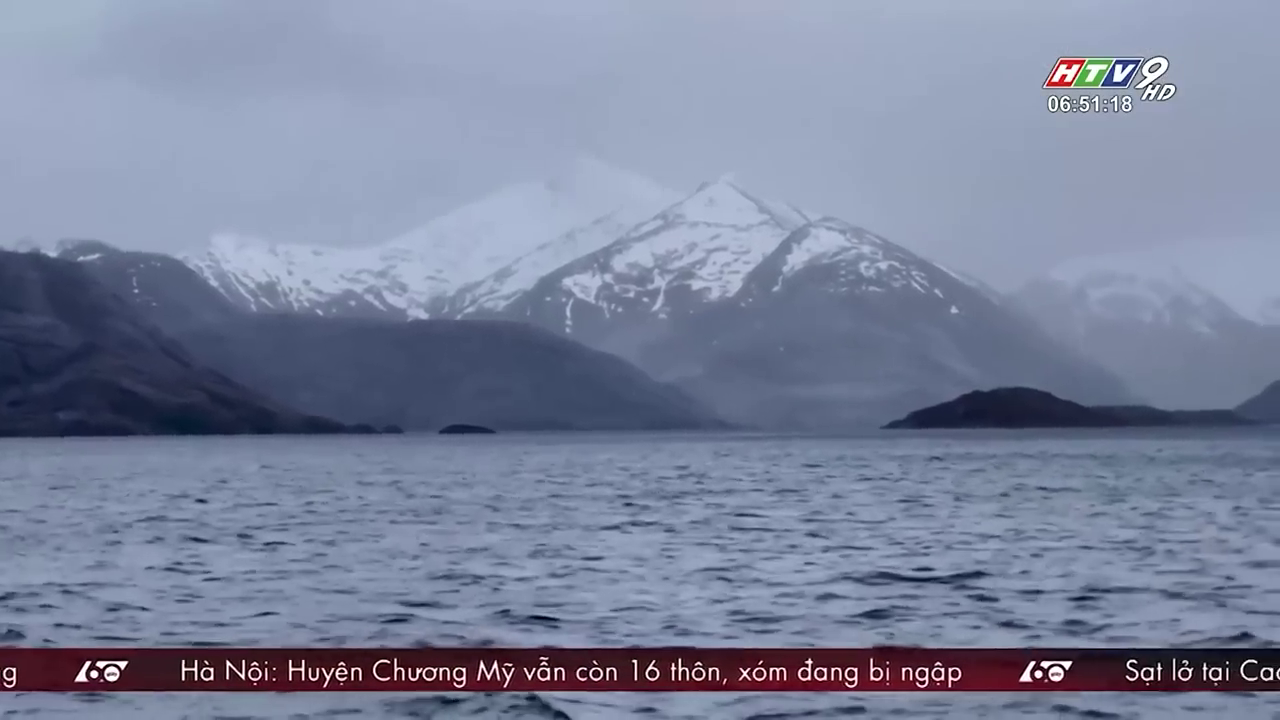

Rank 9 | score 0.139 | hits/frame_2_rank09_score0.139.jpg


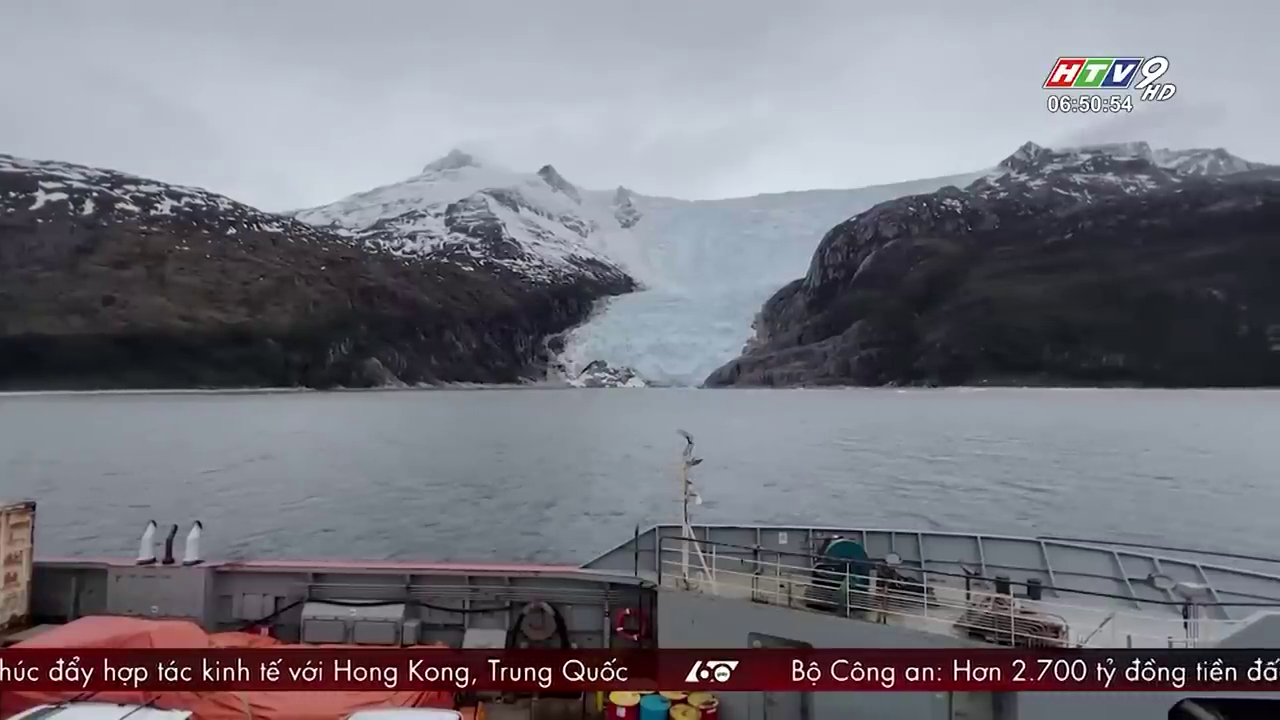

Rank 10 | score 0.137 | hits/frame_2_rank10_score0.137.jpg


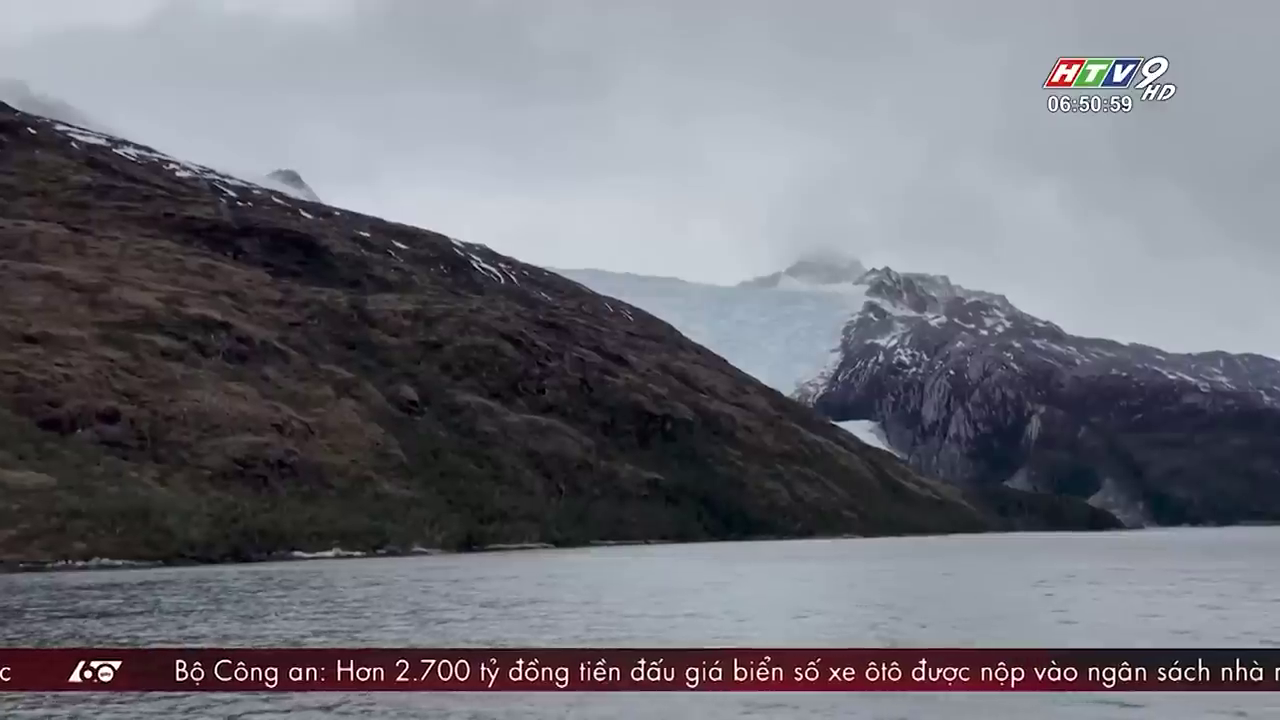

In [17]:
query_vi = "Băng tan ở Nam Cực"
results = search_frames_with_saved_embeddings(image_paths, query_vi, topk=10, save_dir="hits", embedding_path="image_embeddings.pkl")